### 1. Setup and Data Fetching

First, we import the necessary libraries: `yfinance` for downloading stock data, `numpy` for numerical calculations, and `matplotlib` for plotting.

In [1]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Data Fetching ---
ticker = "AAPL"
data = yf.download(ticker, start="2023-01-01", end="2025-09-09", interval="1d")
closing_prices = data["Close"].values.flatten()

# --- 2. Parameter Estimation ---
# Compute logarithmic returns from the historical data
log_returns = np.diff(np.log(closing_prices))

# Use the first half of the data as the "training" period to estimate parameters
half_point = len(log_returns) // 2
mu = np.mean(log_returns[:half_point])       # Mean of log returns (drift)
sigma = np.std(log_returns[:half_point])    # Standard deviation of log returns (volatility)

print(f"Estimated Drift (μ): {mu:.6f}")
print(f"Estimated Volatility (σ): {sigma:.6f}")

/tmp/ipykernel_113276/491513779.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2023-01-01", end="2025-09-09", interval="1d")
[*********************100%***********************]  1 of 1 completed

Estimated Drift (μ): 0.001163
Estimated Volatility (σ): 0.013235


### 2. Monte Carlo Simulation of GRW Paths

Using the estimated parameters `μ` and `σ`, we simulate multiple possible future price paths for AAPL. Each path is a Geometric Random Walk starting from the price at our "halfway" point in the data.

The formula for the GRW at each time step is:
$X_{t+1} = X_t \cdot e^{(\mu \cdot \Delta t + \sigma \cdot \sqrt{\Delta t} \cdot Z)}$
where $Z$ is a random number from a standard normal distribution. We set $\Delta t = 1$ for daily steps.

First, we simulate 20 paths to visualize the potential range of outcomes.

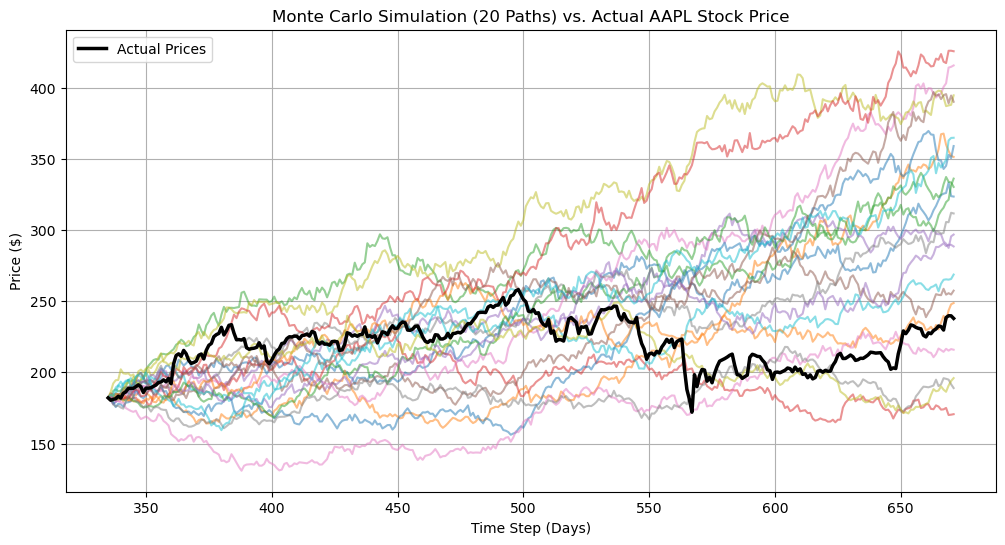

In [2]:
# --- 3. Simulation Setup ---
start_price = closing_prices[half_point]
num_steps = len(closing_prices[half_point:])
num_paths = 20
dt = 1 # Time step is 1 day

# --- 4. Run Monte Carlo Simulation ---
all_paths_20 = []
for _ in range(num_paths):
    price_path = [start_price]
    current_price = start_price
    for i in range(num_steps - 1):
        # Generate random shock from a standard normal distribution
        random_shock = np.random.normal(0, 1)
        # Update price using the GRW formula
        current_price *= np.exp(mu * dt + sigma * np.sqrt(dt) * random_shock)
        price_path.append(current_price)
    all_paths_20.append(price_path)

# --- 5. Plotting the Results ---
plt.figure(figsize=(12, 6))
time_axis = range(half_point, len(closing_prices))

# Plot each simulated path
for path in all_paths_20:
    plt.plot(time_axis, path, alpha=0.5)

# Plot the actual historical prices for comparison
plt.plot(time_axis, closing_prices[half_point:], 'k-', linewidth=2.5, label='Actual Prices')

plt.title(f"Monte Carlo Simulation (20 Paths) vs. Actual AAPL Stock Price")
plt.xlabel("Time Step (Days)")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.show()

### 3. Average Simulated Path vs. Actual Price

While individual paths are highly random, the average of many simulations can give an idea of the expected trend based on the historical drift and volatility. Here, we run 1,000 simulations and plot the average path against the actual price.

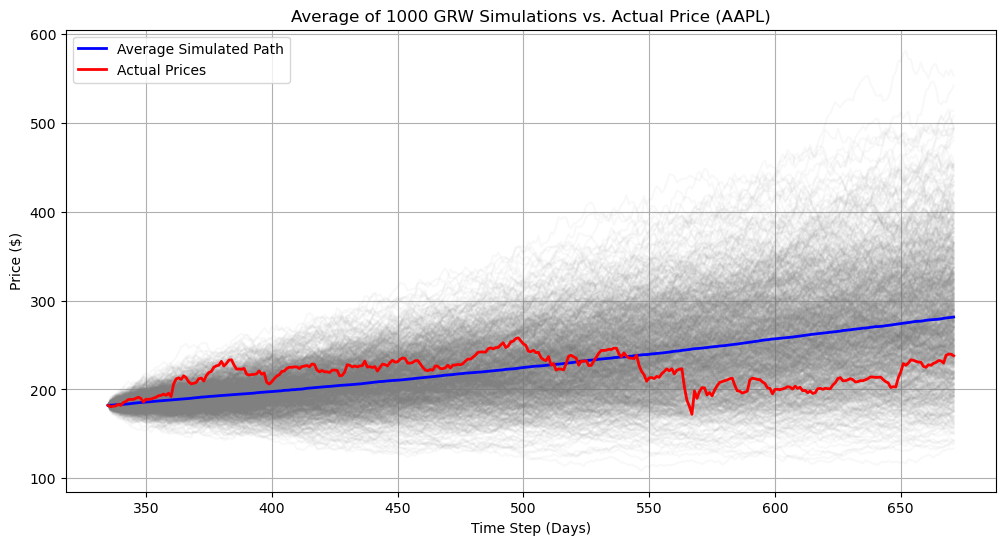

In [3]:
# --- 1. Simulation Setup (More Paths) ---
num_paths_avg = 1000
all_paths_1000 = np.zeros((num_paths_avg, num_steps))
dt = 1

# --- 2. Run Monte Carlo Simulation ---
for i in range(num_paths_avg):
    price = start_price
    path = [price]
    for j in range(num_steps - 1):
        random_shock = np.random.normal(0, 1)
        price *= np.exp(mu * dt + sigma * np.sqrt(dt) * random_shock)
        path.append(price)
    all_paths_1000[i, :] = path

# --- 3. Compute the Average Path ---
average_path = np.mean(all_paths_1000, axis=0)

# --- 4. Plotting the Results ---
plt.figure(figsize=(12, 6))
time_axis = range(half_point, len(closing_prices))

# Plot all simulated paths with high transparency
for path in all_paths_1000:
    plt.plot(time_axis, path, color='gray', alpha=0.05)

# Plot the average path
plt.plot(time_axis, average_path, color='blue', linewidth=2, label='Average Simulated Path')

# Plot the actual price path
plt.plot(time_axis, closing_prices[half_point:], color='red', linewidth=2, label='Actual Prices')

plt.title(f"Average of 1000 GRW Simulations vs. Actual Price (AAPL)")
plt.xlabel("Time Step (Days)")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.show()

### 4. Prediction Error Analysis

Finally, we can analyze the error of a single simulation path over time by subtracting the actual price from the simulated price. This shows how the prediction deviates as we move further into the future.

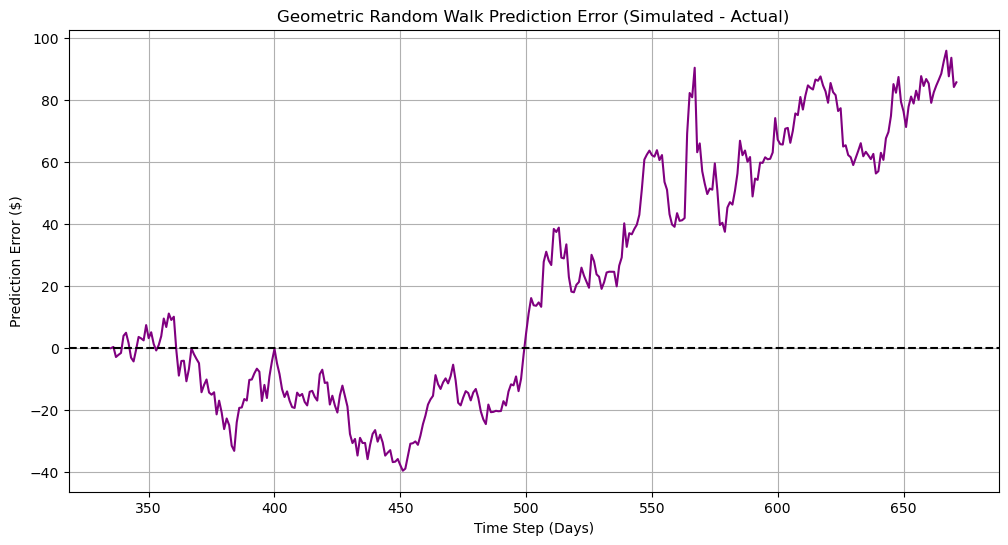

In [4]:
# Calculate the error for one of the simulated paths (e.g., the first one)
prediction_error = np.array(all_paths_20[0]) - closing_prices[half_point:]

# Plot the error
plt.figure(figsize=(12, 6))
plt.plot(range(half_point, len(closing_prices)), prediction_error, color='purple')
plt.axhline(0, color='black', linestyle='--') # Add a zero line for reference
plt.title("Geometric Random Walk Prediction Error (Simulated - Actual)")
plt.xlabel("Time Step (Days)")
plt.ylabel("Prediction Error ($)")
plt.grid(True)
plt.show()